In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
import math
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/wuhan.csv")

### Date Format Manipulation

In [ ]:
df

,date,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
0,2019/9/1,57,32,49,8,45,95,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,2019/9/2,100,35,54,11,38,159,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,2019/9/3,74,23,39,9,25,128,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,2019/9/4,91,25,44,9,27,149,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,2019/9/5,124,29,54,12,38,186,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2020/12/27,216,166,202,21,100,71,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0
484,2020/12/28,186,140,168,15,78,82,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0
485,2020/12/29,79,58,65,5,29,41,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0
486,2020/12/30,43,26,43,7,24,62,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0


In [ ]:
def format(string):
  '''used to convert date format to individual components'''
  count = 0
  year = ""
  month = ""
  date = ""
  for i in string:
    if (i == '/'):
      count = count + 1
  
    elif (count == 0):
      year = year + i
  
    elif (count == 1):
      month = month + i

    elif (count == 2):
      date = date + i
  
  return [year, month, date]

In [ ]:
year = []
month = []
date = []
df.rename(columns = {'date': 'date_1'}, inplace = True)
for i in df.date_1:
  a,b,c = format(i)
  year.append(a)
  month.append(b)
  date.append(c)

In [ ]:
df['year'] = year
df['month'] = month
df['date'] = date

first_column = df.pop('date')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'date', first_column)

first_column = df.pop('month')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(1, 'month', first_column)

first_column = df.pop('year')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(2, 'year', first_column)

In [ ]:
df

,date,month,year,date_1,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
0,1,9,2019,2019/9/1,57,32,49,8,45,95,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,2,9,2019,2019/9/2,100,35,54,11,38,159,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,3,9,2019,2019/9/3,74,23,39,9,25,128,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,4,9,2019,2019/9/4,91,25,44,9,27,149,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,5,9,2019,2019/9/5,124,29,54,12,38,186,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,27,12,2020,2020/12/27,216,166,202,21,100,71,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0
484,28,12,2020,2020/12/28,186,140,168,15,78,82,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0
485,29,12,2020,2020/12/29,79,58,65,5,29,41,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0
486,30,12,2020,2020/12/30,43,26,43,7,24,62,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0


### Handling Missing Data

In [ ]:
df.isna().sum()

date              0
month             0
year              0
date_1            0
AQI               0
PM2.5             0
PM10              0
SO2               0
NO2               0
O3                0
CO                0
l_temp            2
h_temp            2
temp              2
wet               2
wind              2
hpa              24
visibility       24
precipitation     2
cloud            69
dtype: int64

In [ ]:
# Dropping the Rows

df_drop = copy.deepcopy(df)
df_drop = df_drop.dropna()
df_drop

# From 488 to 419 data points, a reduction of about 15% which is a significant reduction

,date,month,year,date_1,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
0,1,9,2019,2019/9/1,57,32,49,8,45,95,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,2,9,2019,2019/9/2,100,35,54,11,38,159,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,3,9,2019,2019/9/3,74,23,39,9,25,128,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,4,9,2019,2019/9/4,91,25,44,9,27,149,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,5,9,2019,2019/9/5,124,29,54,12,38,186,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,27,12,2020,2020/12/27,216,166,202,21,100,71,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0
484,28,12,2020,2020/12/28,186,140,168,15,78,82,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0
485,29,12,2020,2020/12/29,79,58,65,5,29,41,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0
486,30,12,2020,2020/12/30,43,26,43,7,24,62,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0


In [ ]:
# Using Mean/Median

df_central = copy.deepcopy(df)
for i in df_central.columns:
  if (df_central[f"{i}"].isna().sum()>0):
    skew = df_central[f'{i}'].skew(skipna = True)
    if (skew < 0.5 and skew > -0.5):
      mean = np.nanmean(df_central[f"{i}"])
      mean = round(mean,2)
      df_central[f"{i}"].fillna(mean, inplace=True)
      print(f'{i} is imputed using Mean')
    else:
      median = np.nanmedian(df_central[f"{i}"])
      df_central[f"{i}"].fillna(median, inplace=True)
      print(f'{i} is imputed using Median')

# The Features which are almost symmetrical are imputed using the mean value while the skewed ones are imputed using median

l_temp is imputed using Mean
h_temp is imputed using Mean
temp is imputed using Mean
wet is imputed using Mean
wind is imputed using Median
hpa is imputed using Mean
visibility is imputed using Median
precipitation is imputed using Median
cloud is imputed using Mean


In [ ]:
# Using KNN Imputer
imputer_knn = KNNImputer(n_neighbors = 4)
df_knn = copy.deepcopy(df)
df_knn.drop(['date_1', 'month', 'date', 'year'], axis=1, inplace=True)
df_knn = imputer_knn.fit_transform(df_knn)
df_knn = pd.DataFrame(df_knn)

In [ ]:
df_knn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,57.0,32.0,49.0,8.0,45.0,95.0,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,100.0,35.0,54.0,11.0,38.0,159.0,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,74.0,23.0,39.0,9.0,25.0,128.0,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,91.0,25.0,44.0,9.0,27.0,149.0,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,124.0,29.0,54.0,12.0,38.0,186.0,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,216.0,166.0,202.0,21.0,100.0,71.0,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0
484,186.0,140.0,168.0,15.0,78.0,82.0,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0
485,79.0,58.0,65.0,5.0,29.0,41.0,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0
486,43.0,26.0,43.0,7.0,24.0,62.0,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0


In [ ]:
df

,date,month,year,date_1,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
0,1,9,2019,2019/9/1,57,32,49,8,45,95,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,2,9,2019,2019/9/2,100,35,54,11,38,159,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,3,9,2019,2019/9/3,74,23,39,9,25,128,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,4,9,2019,2019/9/4,91,25,44,9,27,149,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,5,9,2019,2019/9/5,124,29,54,12,38,186,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,27,12,2020,2020/12/27,216,166,202,21,100,71,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0
484,28,12,2020,2020/12/28,186,140,168,15,78,82,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0
485,29,12,2020,2020/12/29,79,58,65,5,29,41,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0
486,30,12,2020,2020/12/30,43,26,43,7,24,62,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0


In [ ]:
# Renaming the columns
for i in range(len(df_knn.columns)):
  df_knn.rename(columns = {df_knn.columns[i]: df.columns[i+4]}, inplace = True)

In [ ]:
df_knn['date_1'] = df.date_1
df_knn['date'] = df.date
df_knn['month'] = df.month
df_knn['year'] = df.year

#### We will go ahead with KNN imputed data as our dataset for now

### Scatter Plots

In [ ]:
df_knn

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud,date_1,date,month,year
0,57.0,32.0,49.0,8.0,45.0,95.0,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0,2019/9/1,1,9,2019
1,100.0,35.0,54.0,11.0,38.0,159.0,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0,2019/9/2,2,9,2019
2,74.0,23.0,39.0,9.0,25.0,128.0,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0,2019/9/3,3,9,2019
3,91.0,25.0,44.0,9.0,27.0,149.0,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0,2019/9/4,4,9,2019
4,124.0,29.0,54.0,12.0,38.0,186.0,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0,2019/9/5,5,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,216.0,166.0,202.0,21.0,100.0,71.0,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0,2020/12/27,27,12,2020
484,186.0,140.0,168.0,15.0,78.0,82.0,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0,2020/12/28,28,12,2020
485,79.0,58.0,65.0,5.0,29.0,41.0,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0,2020/12/29,29,12,2020
486,43.0,26.0,43.0,7.0,24.0,62.0,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0,2020/12/30,30,12,2020


In [ ]:
data = copy.deepcopy(df_knn)

Intercept:  37.73240779695292
Slope:  0.9681094356686757


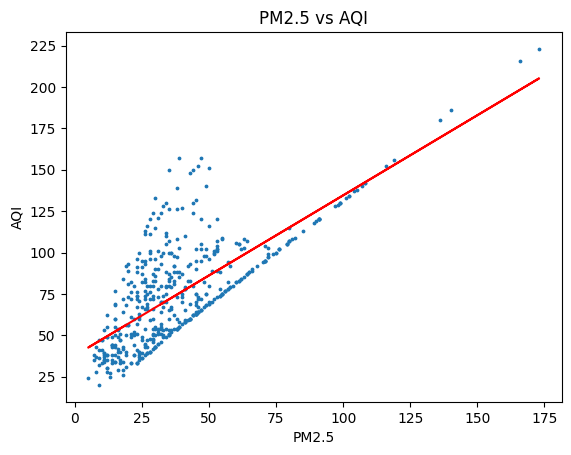

In [ ]:
# PM2.5 vs AQI
pm_data = data['PM2.5'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.title('PM2.5 vs AQI')
plt.show()

Intercept:  29.16221109480213
Slope:  0.7510157089229536


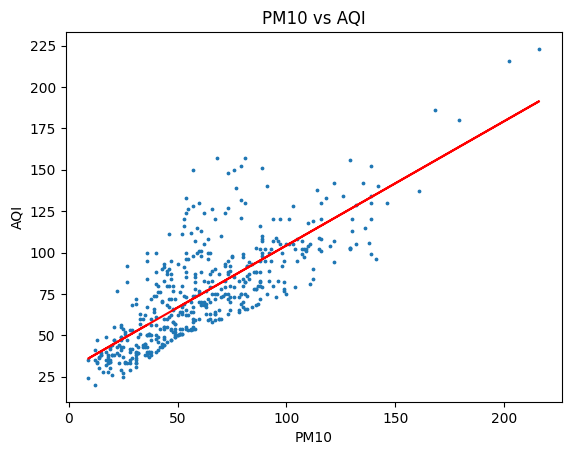

In [ ]:
# PM10 vs AQI
data = copy.deepcopy(df_knn)

pm_data = data['PM10'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.title('PM10 vs AQI')
plt.show()

Intercept:  75.80554152450568
Slope:  0.0050787789131919725


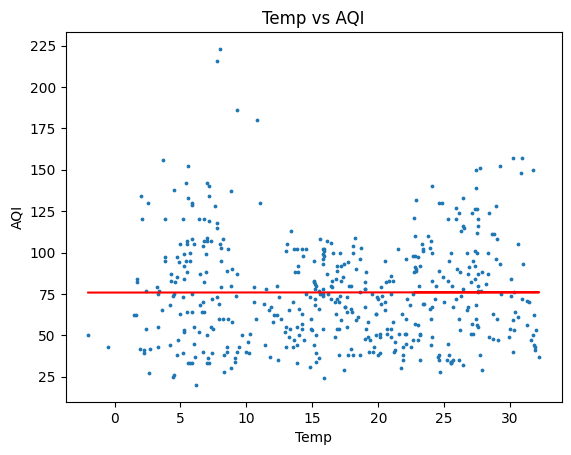

In [ ]:
# Temp vs AQI
pm_data = data['temp'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Temp')
plt.ylabel('AQI')
plt.title('Temp vs AQI')
plt.show()

Intercept:  78.68334338389515
Slope:  -0.870908845959907


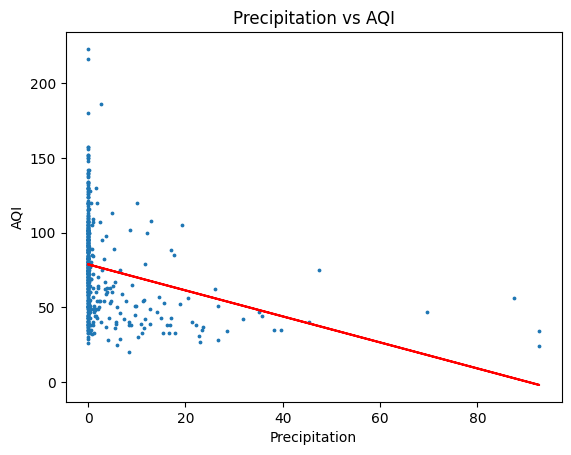

In [ ]:
# Precipitation vs AQI
pm_data = data['precipitation'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Precipitation')
plt.ylabel('AQI')
plt.title('Precipitation vs AQI')
plt.show()

In [ ]:
data.precipitation.value_counts()
# Since most of the time, the value of precipitation is 0, we can remove the 0 values to see the effect of precipitation

0.0     316
0.1      20
0.2       7
0.6       6
0.3       6
       ... 
16.6      1
5.7       1
26.7      1
4.2       1
23.6      1
Name: precipitation, Length: 100, dtype: int64

Intercept:  64.04793474127626
Slope:  -0.4488836316854552


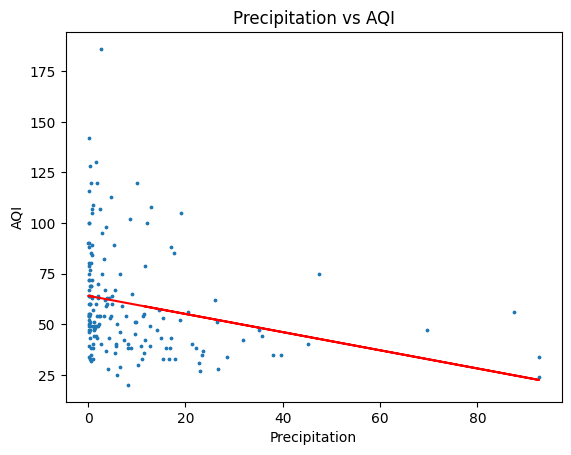

In [ ]:
# Precipitation vs AQI
data_prec = copy.deepcopy(data)
for i in range(len(data.precipitation)):
  if(data.precipitation.iloc[i] == 0):
    data_prec.iloc[i] = np.nan

data_prec.dropna(inplace=True)
pm_data = data_prec['precipitation'].values.reshape(-1, 1)
aqi_data = data_prec['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Precipitation')
plt.ylabel('AQI')
plt.title('Precipitation vs AQI')
plt.show()

In [ ]:
print("Correlation between Precipitation and AQI before pruning ", np.corrcoef(data.AQI, data.precipitation)[0][1])
print("Correlation between Precipitation and AQI after pruning ", np.corrcoef(data_prec.AQI, data_prec.precipitation)[0][1])

# No significant difference was seen

Correlation between Precipitation and AQI before pruning  -0.27889314743900295
Correlation between Precipitation and AQI after pruning  -0.26021914375250577


Intercept:  89.72976229065713
Slope:  -10.76752740118895


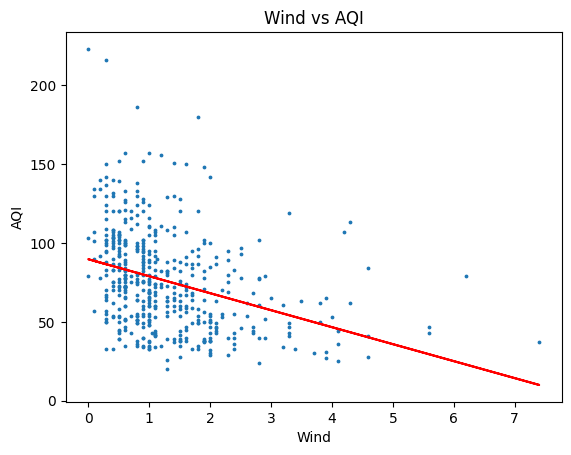

In [ ]:
# Wind vs AQI
pm_data = data['wind'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Wind')
plt.ylabel('AQI')
plt.title('Wind vs AQI')
plt.show()

Intercept:  170.6683577200662
Slope:  -1.2101376531084662


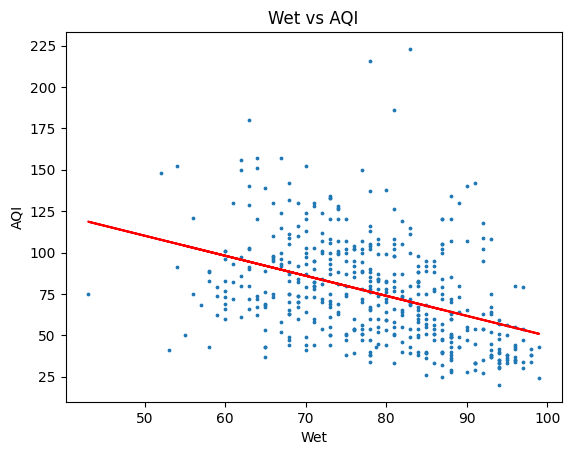

In [ ]:
# Wet vs AQI
pm_data = data['wet'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Wet')
plt.ylabel('AQI')
plt.title('Wet vs AQI')
plt.show()

Intercept:  88.77724715361504
Slope:  -1.251863195597212


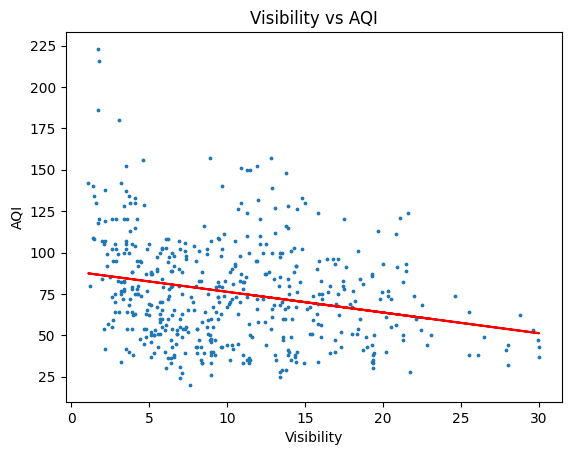

In [ ]:
# Visibility vs AQI
pm_data = data['visibility'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('Visibility')
plt.ylabel('AQI')
plt.title('Visibility vs AQI')
plt.show()

Intercept:  27.977701647525265
Slope:  5.551253940172762


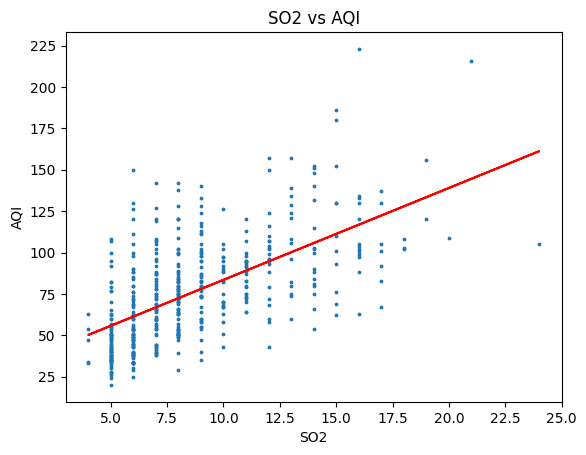

In [ ]:
# SO2 vs AQI
pm_data = data['SO2'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('SO2')
plt.ylabel('AQI')
plt.title('SO2 vs AQI')
plt.show()

Intercept:  38.804935639328086
Slope:  0.9312164346801078


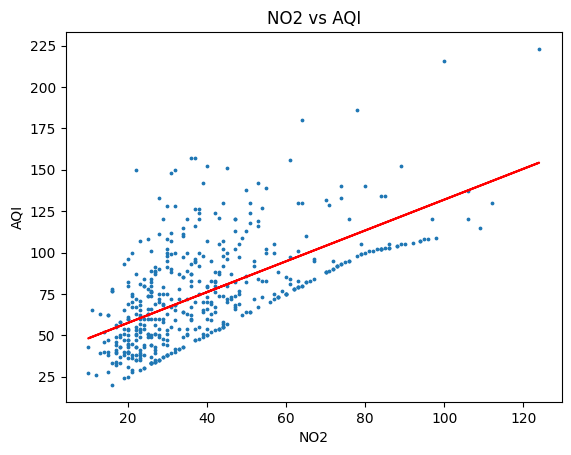

In [ ]:
# NO2 vs AQI
pm_data = data['NO2'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('NO2')
plt.ylabel('AQI')
plt.title('NO2 vs AQI')
plt.show()

Intercept:  9.14385693945026
Slope:  75.50486280377439


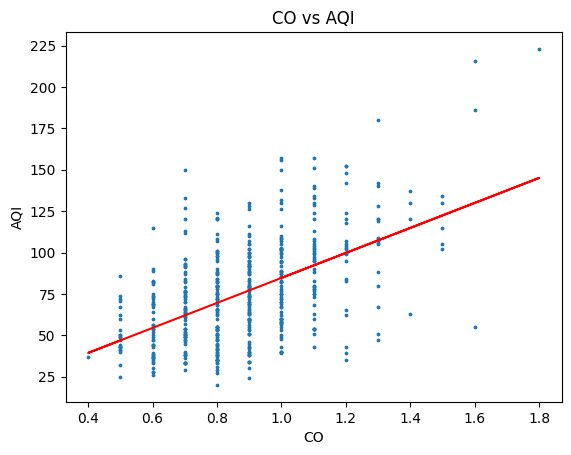

In [ ]:
# CO vs AQI
pm_data = data['CO'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('CO')
plt.ylabel('AQI')
plt.title('CO vs AQI')
plt.show()

Intercept:  53.37155332908382
Slope:  0.24338763704310012


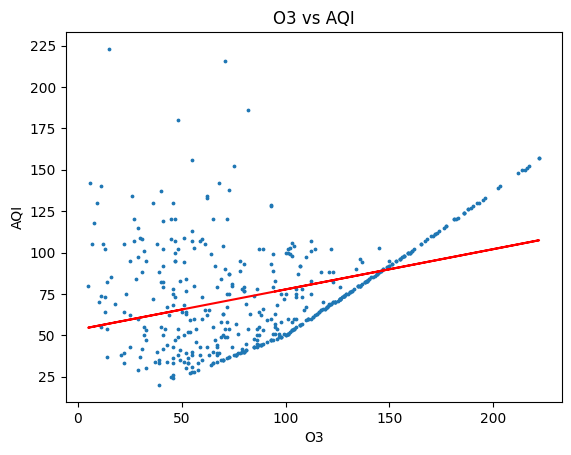

In [ ]:
# O3 vs AQI
pm_data = data['O3'].values.reshape(-1, 1)
aqi_data = data['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('O3')
plt.ylabel('AQI')
plt.title('O3 vs AQI')
plt.show()

In [ ]:
data.O3.value_counts()

46.0     9
126.0    8
55.0     7
73.0     7
80.0     7
        ..
130.0    1
170.0    1
133.0    1
143.0    1
15.0     1
Name: O3, Length: 174, dtype: int64

Intercept:  -32.03395043466146
Slope:  0.8383074508843372


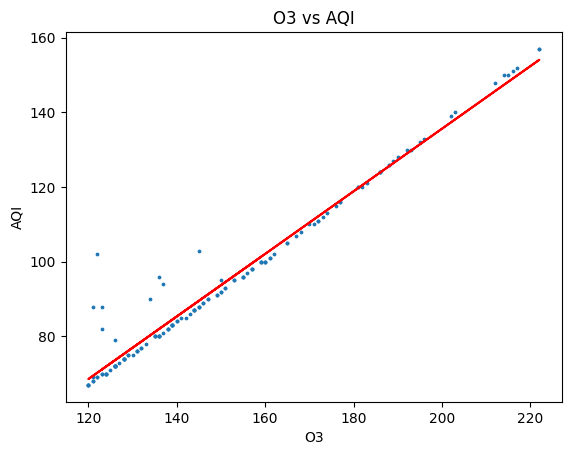

In [ ]:
# O3 vs AQI
data_o3 = copy.deepcopy(data)
for i in range(len(data.O3)):
  if(data.O3.iloc[i] < 120):
    data_o3.iloc[i] = np.nan

data_o3.dropna(inplace=True)
pm_data = data_o3['O3'].values.reshape(-1, 1)
aqi_data = data_o3['AQI'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, aqi_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, aqi_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('O3')
plt.ylabel('AQI')
plt.title('O3 vs AQI')
plt.show()

In [ ]:
print("Correlation between O3 and AQI before pruning ", np.corrcoef(data.AQI, data.O3)[0][1])
print("Correlation between O3 and AQI after pruning ", np.corrcoef(data_o3.AQI, data_o3.O3)[0][1])

# There exists a very strong correlation between higher values of O3 and AQI even though it is not noticeable for smaller values

Correlation between O3 and AQI before pruning  0.36232678250660744
Correlation between O3 and AQI after pruning  0.98066753615097


### Time Series Graph of AQI with Indication of Mean

Text(0, 0.5, 'AQI')

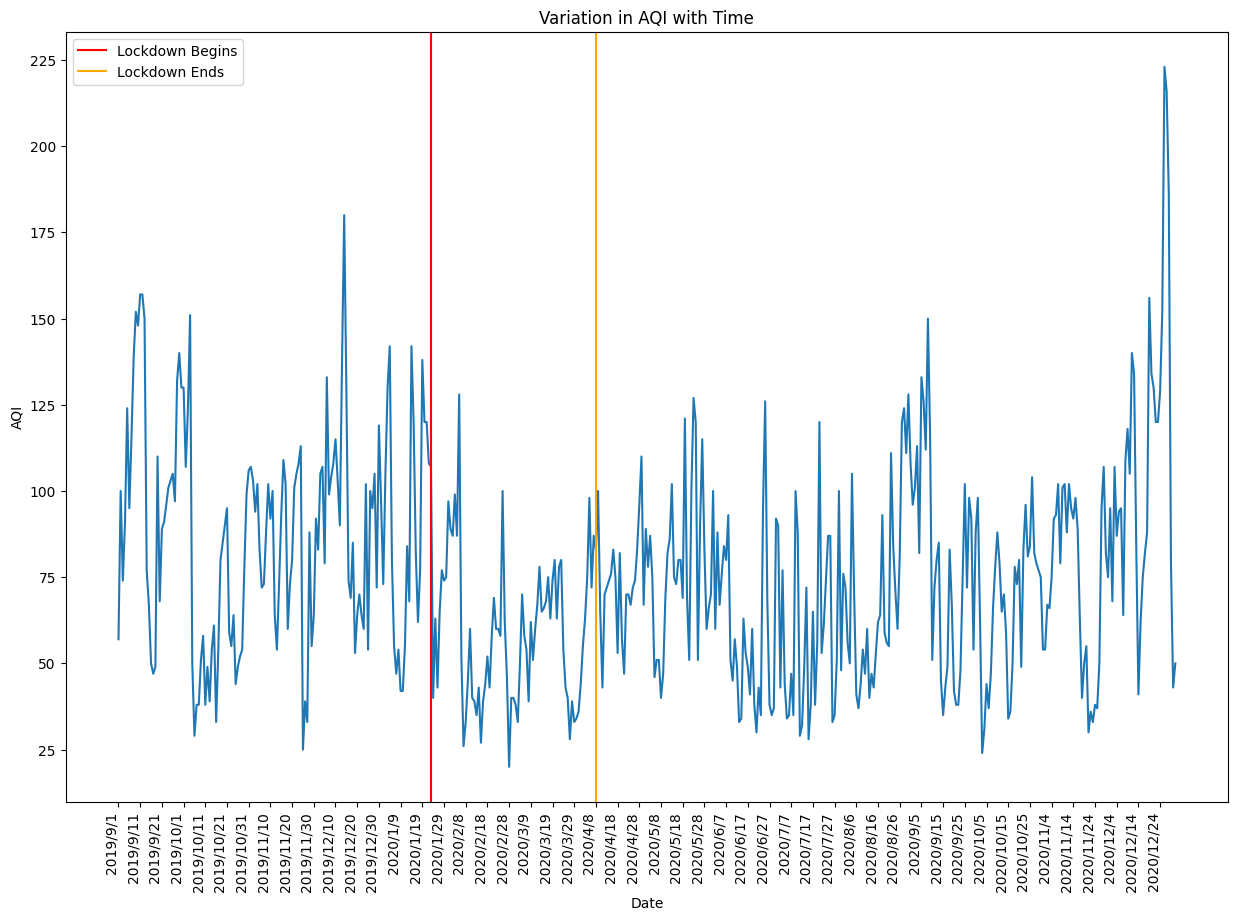

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(data.date_1, data.AQI)

plt.title('Variation in AQI with Time')
plt.axvline('2020/1/23', 0, 1, color = 'red', label= 'Lockdown Begins')
plt.axvline('2020/4/8', 0, 1, color = 'orange', label = 'Lockdown Ends')
plt.legend()

plt.xticks(rotation=90, ha='right')
plt.xticks(np.arange(0, len(data.date_1)+1, 10))

plt.xlabel('Date')
plt.ylabel('AQI')

In [ ]:
# Calculation of AQI Mean - A. For entire period   B. For lockdown period   
# Plot it to visualize the difference

total = 0
lockdown = []

for i in range(len(data.AQI)):
  total = total + data.AQI.iloc[i]

flag = False
for i in range(len(data.AQI)):
  if (data.date_1.iloc[i] == "2020/1/23"):
    flag = True
  
  if (data.date_1.iloc[i] == "2020/4/8"):
    flag = False
  
  if(flag == True):
    lockdown.append(data.AQI.iloc[i])


AQI_mean = total/len(data.AQI)
AQI_mean_ld = sum(lockdown)/76

In [ ]:
AQI_mean

75.89139344262296

In [ ]:
AQI_mean_ld

59.14473684210526

Text(0, 0.5, 'AQI')

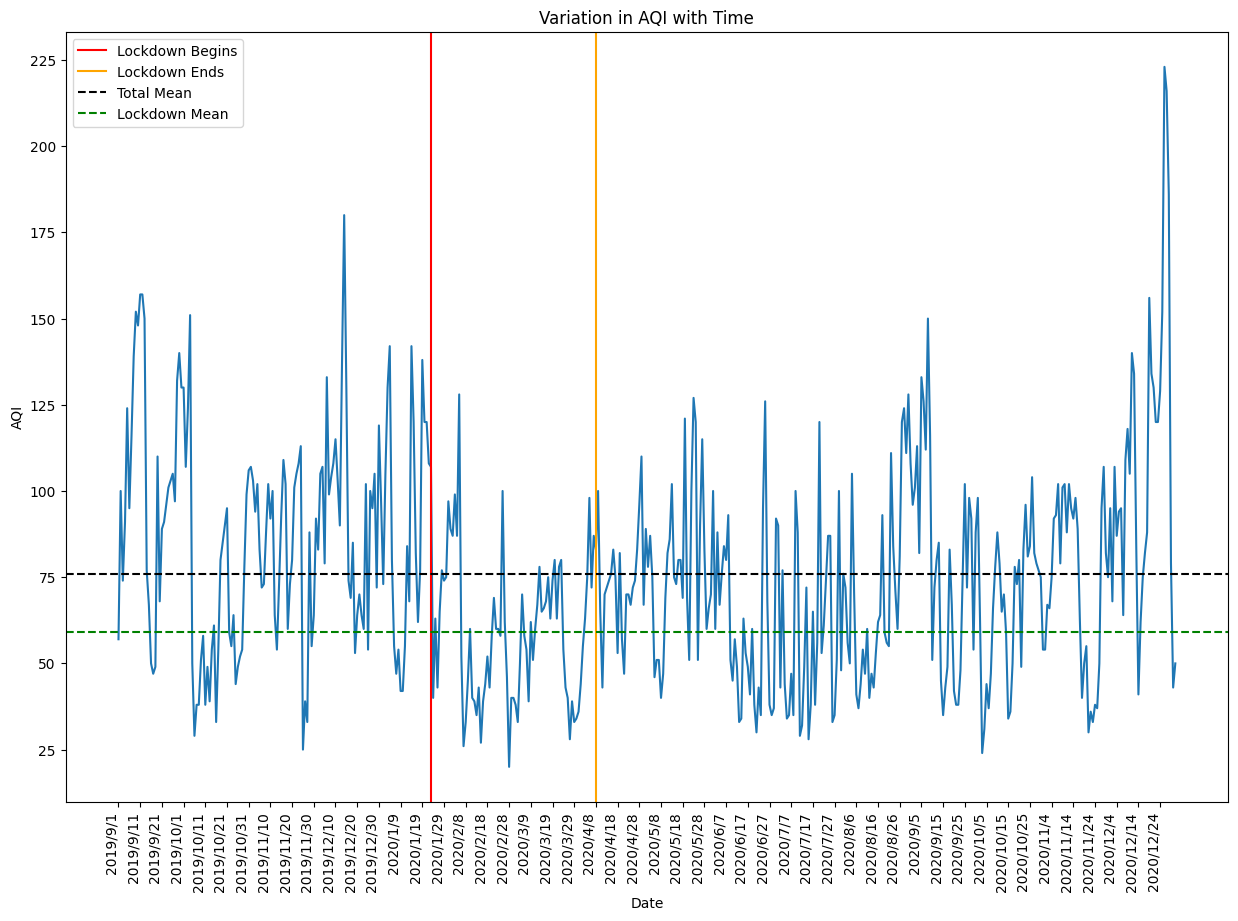

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(data.date_1, data.AQI)

plt.title('Variation in AQI with Time')
plt.axvline('2020/1/23', 0, 1, color = 'red', label= 'Lockdown Begins')
plt.axvline('2020/4/8', 0, 1, color = 'orange', label = 'Lockdown Ends')

plt.axhline(y = AQI_mean, color = 'black', linestyle = 'dashed', label = "Total Mean")    
plt.axhline(y = AQI_mean_ld, color = 'green', linestyle = 'dashed', label = "Lockdown Mean")    

plt.legend()

plt.xticks(rotation=90, ha='right')
plt.xticks(np.arange(0, len(data.date_1)+1, 10))

plt.xlabel('Date')
plt.ylabel('AQI')

### Correlation Matrix

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='BrBG_r')

<ipython-input-41-78951a913231>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
AQI,1.000000,0.734405,0.782670,0.604296,0.620819,0.362327,0.531319,0.133517,-0.111469,0.001383,-0.406345,-0.340963,0.065504,-0.243987,-0.278893,-0.397504
PM2.5,0.734405,1.000000,0.889019,0.515795,0.615394,-0.225630,0.692629,-0.386651,-0.516350,-0.473048,-0.117796,-0.245977,0.428449,-0.629414,-0.211208,-0.026042
PM10,0.782670,0.889019,1.000000,0.698773,0.782781,-0.051678,0.646969,-0.177671,-0.397908,-0.307931,-0.328684,-0.306104,0.349682,-0.471514,-0.282492,-0.183062
SO2,0.604296,0.515795,0.698773,1.000000,0.708847,0.137399,0.510403,0.008447,-0.268774,-0.141429,-0.547787,-0.374239,0.227543,-0.123178,-0.268066,-0.233286
NO2,0.620819,0.615394,0.782781,0.708847,1.000000,-0.085965,0.562643,-0.098223,-0.339827,-0.244351,-0.195683,-0.477465,0.287187,-0.334529,-0.209034,-0.261797
O3,0.362327,-0.225630,-0.051678,0.137399,-0.085965,1.000000,-0.152749,0.780340,0.558054,0.684738,-0.474567,-0.165631,-0.515095,0.393678,-0.168162,-0.523990
CO,0.531319,0.692629,0.646969,0.510403,0.562643,-0.152749,1.000000,-0.193272,-0.301488,-0.266579,0.071542,-0.329035,0.183688,-0.565595,-0.077440,0.064950
l_temp,0.133517,-0.386651,-0.177671,0.008447,-0.098223,0.780340,-0.193272,1.000000,0.880127,0.964982,-0.259792,-0.023339,-0.827861,0.586766,-0.044531,-0.452292
h_temp,-0.111469,-0.516350,-0.397908,-0.268774,-0.339827,0.558054,-0.301488,0.880127,1.000000,0.969151,0.026216,0.157227,-0.877765,0.567547,0.098424,-0.182136
temp,0.001383,-0.473048,-0.307931,-0.141429,-0.244351,0.684738,-0.266579,0.964982,0.969151,1.000000,-0.124004,0.080830,-0.887419,0.605070,0.027430,-0.314067


In [ ]:
# Significant Positive Correlation between O3 and Temperature -- Worth Exploring
# Significant Negative Correlation between Visibility and CO -- Worth Exploring
# Significant Negative Correlation between SO2 and Wet -- Worth Exploring
# Significant Negative Correlation between NO2 and Wind -- Worth Exploring
# Significant Negative Correlation between O3 and Cloud -- Worth Exploring

Intercept:  5.312706338303956
Slope:  0.12527571383756714


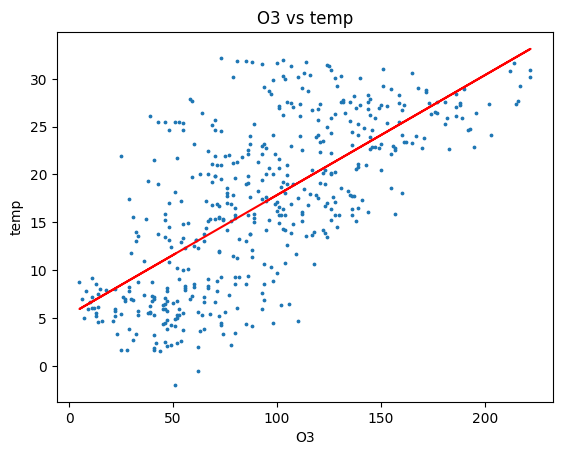

In [ ]:
# O3 vs temp
pm_data = data['O3'].values.reshape(-1, 1)
temp_data = data['temp'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, temp_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, temp_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('O3')
plt.ylabel('temp')
plt.title('O3 vs temp')
plt.show()

Intercept:  24.14160330312109
Slope:  -15.665165535287649


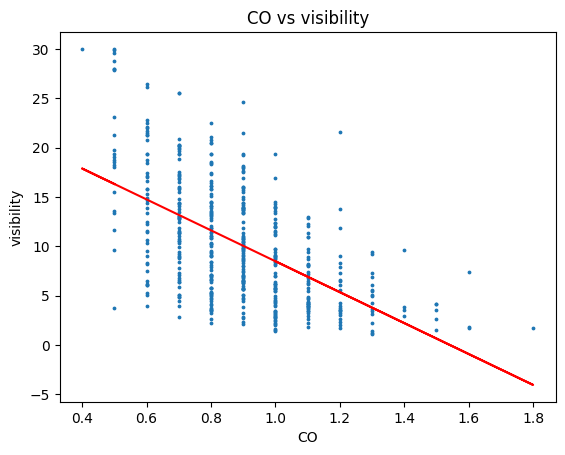

In [ ]:
# CO vs visibility
pm_data = data['CO'].values.reshape(-1, 1)
visibility_data = data['visibility'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, visibility_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, visibility_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('CO')
plt.ylabel('visibility')
plt.title('CO vs visibility')
plt.show()

Intercept:  92.90332062201426
Slope:  -1.6897128355989932


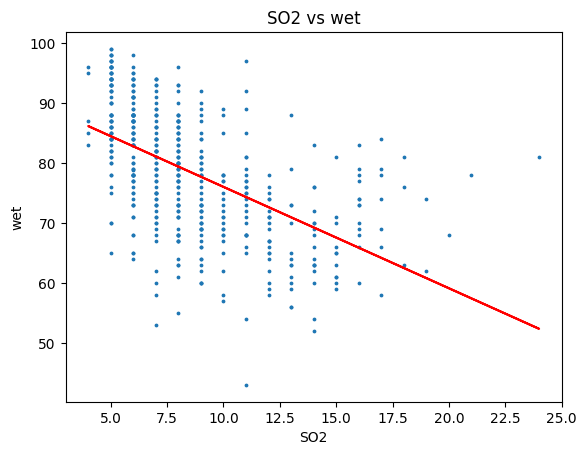

In [ ]:
# SO2 vs wet
pm_data = data['SO2'].values.reshape(-1, 1)
wet_data = data['wet'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, wet_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, wet_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('SO2')
plt.ylabel('wet')
plt.title('SO2 vs wet')
plt.show()

Intercept:  52.74496139678898
Slope:  -10.052283910603936


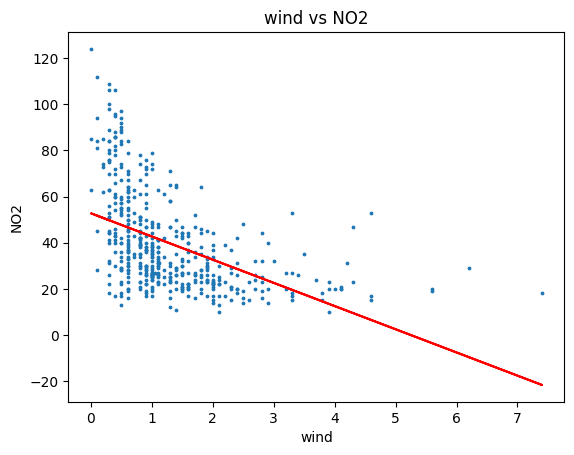

In [ ]:
# wind vs NO2
pm_data = data['wind'].values.reshape(-1, 1)
NO2_data = data['NO2'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, NO2_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, NO2_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('wind')
plt.ylabel('NO2')
plt.title('wind vs NO2')
plt.show()

#### There is some empirical evidence as to NO2 getting affected due to winds which is verified by a primitive Google Search

Intercept:  95.08750410568291
Slope:  -0.36087196871909416


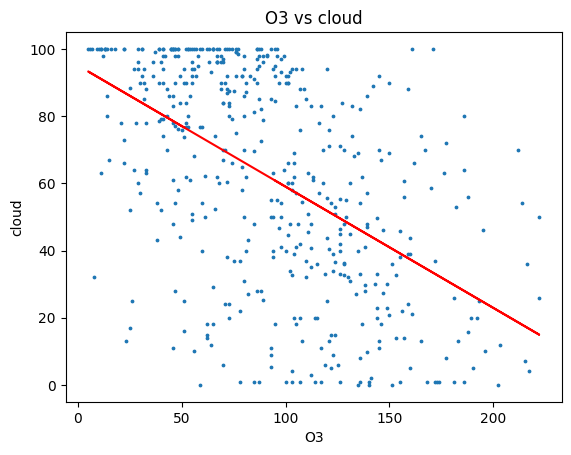

In [ ]:
# O3 vs cloud
pm_data = data['O3'].values.reshape(-1, 1)
cloud_data = data['cloud'].values.reshape(-1, 1)

reg = LinearRegression().fit(pm_data, cloud_data)

print('Intercept: ', reg.intercept_[0])
print('Slope: ', reg.coef_[0][0])

plt.scatter(pm_data, cloud_data, s=3)
plt.plot(pm_data, reg.predict(pm_data), color='red')
plt.xlabel('O3')
plt.ylabel('cloud')
plt.title('O3 vs cloud')
plt.show()

### Covariance Analysis

In [ ]:
cov = data.cov()
cov.style.background_gradient(cmap='BrBG_r')

<ipython-input-48-206171796e68>:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov = data.cov()


,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
AQI,985.908098,549.267037,804.163716,64.855135,408.052913,531.788320,3.686146,37.809162,-30.389417,0.371436,-134.521221,-10.644732,19.064638,-46.882758,-88.052039,-401.799890
PM2.5,549.267037,567.360483,692.928283,41.993587,306.842625,-251.215416,3.645266,-83.059626,-106.788326,-96.360106,-29.582730,-5.825502,94.595051,-91.747429,-50.585216,-19.968765
PM10,804.163716,692.928283,1070.768169,78.155721,536.192631,-79.044922,4.677672,-52.433078,-113.052607,-86.171483,-113.397781,-9.959242,106.062224,-94.421418,-92.947485,-192.839941
SO2,64.855135,41.993587,78.155721,11.682970,50.717962,21.952351,0.385468,0.260383,-7.976524,-4.134079,-19.740865,-1.271848,7.209092,-2.576538,-9.213004,-25.669400
NO2,408.052913,306.842625,536.192631,50.717962,438.193418,-84.115474,2.602344,-18.543424,-61.764810,-43.743185,-43.188134,-9.937646,55.723438,-42.854345,-43.998014,-176.419887
O3,531.788320,-251.215416,-79.044922,21.952351,-84.115474,2184.943847,-1.577602,328.962131,226.488861,273.720400,-233.881466,-7.697885,-223.175941,112.613319,-79.037193,-788.484988
CO,3.686146,3.645266,4.677672,0.385468,2.602344,-1.577602,0.048820,-0.385133,-0.578389,-0.503719,0.166662,-0.072285,0.376201,-0.764773,-0.172048,0.461989
l_temp,37.809162,-83.059626,-52.433078,0.260383,-18.543424,328.962131,-0.385133,81.336118,68.918782,74.425823,-24.702739,-0.209281,-69.205210,32.384344,-4.038154,-131.313953
h_temp,-30.389417,-106.788326,-113.052607,-7.976524,-61.764810,226.488861,-0.578389,68.918782,75.387729,71.962197,2.399936,1.357331,-70.642886,30.156435,8.592772,-50.909168
temp,0.371436,-96.360106,-86.171483,-4.134079,-43.743185,273.720400,-0.503719,74.425823,71.962197,73.134969,-11.180876,0.687298,-70.344640,31.666235,2.358655,-86.463954


### Summary Statistics

In [ ]:
data.describe()

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
count,488.000000,488.000000,488.000000,488.000000,488.00000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,75.891393,39.415984,62.221311,8.631148,39.82582,92.526639,0.884016,21.292674,12.955738,16.904047,78.319160,1.285195,1014.744877,10.293340,3.205789,61.697234
std,31.399174,23.819330,32.722594,3.418036,20.93307,46.743383,0.220952,9.018654,8.682611,8.551899,10.543335,0.994282,9.269146,6.119672,10.055030,32.192195
min,20.000000,5.000000,9.000000,4.000000,10.00000,5.000000,0.400000,2.400000,-7.600000,-2.000000,43.000000,0.000000,996.000000,1.100000,0.000000,0.000000
25%,51.000000,24.000000,38.000000,6.000000,24.00000,55.000000,0.700000,13.800000,5.500000,8.575000,70.000000,0.600000,1007.000000,5.475000,0.000000,36.000000
50%,73.000000,34.000000,57.000000,8.000000,34.00000,88.000000,0.900000,22.250000,12.600000,17.100000,78.000000,1.000000,1016.000000,9.150000,0.000000,66.000000
75%,95.250000,49.000000,81.000000,10.000000,49.25000,124.250000,1.000000,28.750000,20.525000,24.100000,87.000000,1.700000,1022.000000,14.025000,0.825000,92.000000
max,223.000000,173.000000,216.000000,24.000000,124.00000,222.000000,1.800000,37.300000,30.400000,32.200000,99.000000,7.400000,1037.000000,30.000000,92.700000,100.000000


In [ ]:
start = (data[data['date_1']=='2020/1/23'].index.values)
start = start[0]

In [ ]:
data_ld = data.iloc[144:(144+76)]
data_ld.describe()

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,59.144737,38.289474,51.565789,8.092105,21.934211,85.315789,0.903947,15.086842,6.459211,10.684211,78.078947,1.267105,1019.381579,8.446053,2.675000,78.016447
std,21.540476,17.661118,22.414481,2.757669,6.792811,26.438462,0.195578,5.589498,4.880988,4.770802,8.737297,0.883989,6.050823,3.996647,6.188099,26.895673
min,20.000000,8.000000,12.000000,5.000000,10.000000,39.000000,0.500000,4.000000,-2.000000,2.200000,60.000000,0.300000,1006.000000,2.200000,0.000000,0.000000
25%,40.000000,27.000000,33.500000,6.000000,17.000000,64.500000,0.800000,11.200000,3.350000,6.875000,71.000000,0.600000,1015.000000,5.675000,0.000000,58.750000
50%,59.000000,36.500000,51.000000,7.500000,21.000000,83.000000,0.900000,14.850000,5.450000,10.150000,78.000000,1.000000,1021.000000,7.400000,0.000000,91.000000
75%,74.000000,47.000000,69.250000,9.250000,26.000000,102.250000,1.000000,19.150000,10.375000,14.275000,85.000000,1.725000,1023.000000,10.250000,1.000000,100.000000
max,128.000000,97.000000,103.000000,17.000000,43.000000,157.000000,1.400000,26.700000,18.000000,19.800000,94.000000,4.600000,1032.000000,19.400000,26.700000,100.000000


In [ ]:
mean_aqi = []
for i in range(56):
  d = data_ld.iloc[i:i+20]
  x = d.describe()
  mean = x._get_value('mean', 'AQI')
  mean_aqi.append(mean)

In [ ]:
def min_index(main):
  min_index = 0
  min_val = main[0]
  for i in range(len(main)):
    if(main[i]<min_val):
      min_val = main[i]
      min_index = i
  return(min_index)

In [ ]:
peak = min_index(mean_aqi)
data_peak = data_ld.iloc[peak:peak+20]
data_peak.describe()

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
count,20.000000,20.0000,20.000000,20.00000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,48.350000,30.4000,39.950000,7.55000,18.550000,76.65000,0.925000,14.175000,5.265000,9.725000,78.35000,1.400000,1021.500000,10.030000,4.470000,79.70000
std,17.532751,15.7994,19.115921,2.48098,4.310025,21.29313,0.186025,4.775251,4.650781,4.447811,9.78331,0.928496,6.581473,4.649629,8.320305,25.57363
min,20.000000,9.0000,12.000000,5.00000,10.000000,39.00000,0.600000,6.600000,-1.800000,2.200000,60.00000,0.300000,1010.000000,3.700000,0.000000,22.00000
25%,38.750000,20.7500,25.750000,6.00000,15.750000,57.75000,0.800000,11.025000,2.650000,6.850000,71.00000,0.600000,1017.250000,6.375000,0.000000,69.00000
50%,43.500000,29.0000,36.000000,6.50000,18.000000,80.00000,0.900000,13.900000,4.850000,9.350000,77.50000,1.150000,1021.500000,8.700000,0.150000,90.00000
75%,58.500000,41.0000,53.250000,9.00000,21.250000,98.50000,1.000000,17.250000,8.575000,12.325000,87.25000,2.000000,1027.000000,12.700000,2.825000,98.50000
max,100.000000,75.0000,89.000000,13.00000,29.000000,104.00000,1.200000,24.000000,13.700000,19.200000,94.00000,3.900000,1032.000000,19.300000,26.000000,100.00000


#### Some Empirical Analysis on the Mean of AQI, PM2.5 
1. There is a general trend of reduction in the mean of Pollutant Indicators during Lockdown which is completely justified given the reduction in Polluting Factors.

2. The reduction in PM2.5 levels were not too evident and required further exploration.

3. On doing so, it was found that the minimum level of PM2.5 was recorded between the time frame - 21st to 41st day of the Lockdown. This lower bound was in sync with the AQI level, a testimony of their strong correlation.

4. One explanation could be that people were the most "obedient" of the lockdown imposed during this particular period, however this explanation makes little sense as People are expectedly the most afraid during the beginning rather than in the middle. This also has an inherent assumption that PM 2.5 levels take little to no time in getting back to a "normal" condition.

5. The second and more sound explanation would be the fact that it takes time for the PM2.5 levels to settle down, and this is why the greatest effect is seen between 21 and 41st days of the lockdown.

6. Also helps higlight the fact that people slowly got lenient with the rules.

7. A degree 2 regression on the Pollutants can help visualise the Hypothesis


In [ ]:
aqi = data_ld.AQI
pm = data_ld['PM2.5']
y = [i+1 for i in range(76)]

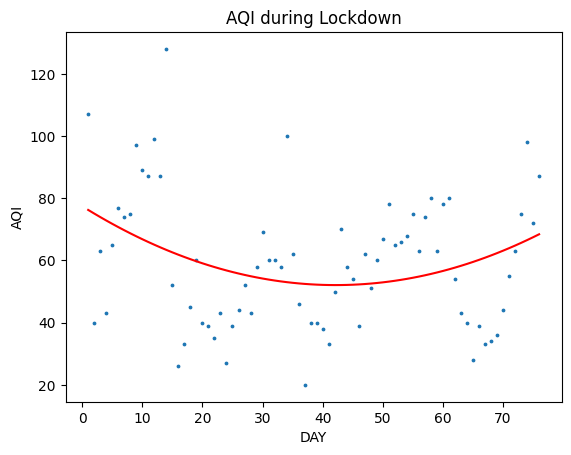

In [ ]:
plt.scatter(y, aqi, s=3)
y = np.array(y)
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(y.reshape(-1,1))
poly_reg.fit(X_poly, aqi)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, aqi)
y_pred = lin_reg.predict(poly_reg.fit_transform(y.reshape(-1,1)))

plt.plot(y, y_pred, color='red')
plt.xlabel('DAY')
plt.ylabel('AQI')
plt.title('AQI during Lockdown')

plt.show()

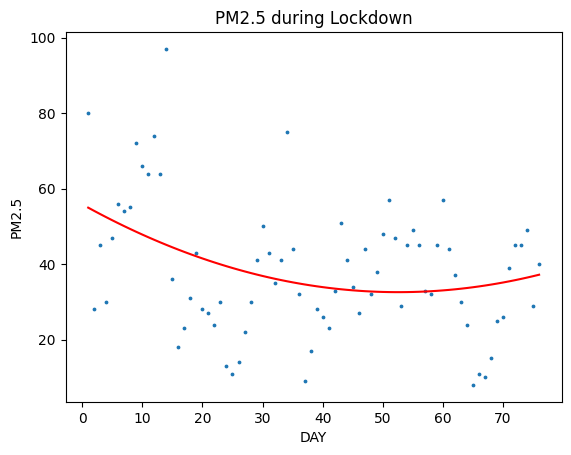

In [ ]:
plt.scatter(y, pm, s=3)
y = np.array(y)
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(y.reshape(-1,1))
poly_reg.fit(X_poly, pm)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, pm)
y_pred = lin_reg.predict(poly_reg.fit_transform(y.reshape(-1,1)))

plt.plot(y, y_pred, color='red')
plt.xlabel('DAY')
plt.ylabel('PM2.5')
plt.title('PM2.5 during Lockdown')

plt.show()

In [ ]:
data

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud,date_1,date,month,year
0,57.0,32.0,49.0,8.0,45.0,95.0,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0,2019/9/1,1,9,2019
1,100.0,35.0,54.0,11.0,38.0,159.0,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0,2019/9/2,2,9,2019
2,74.0,23.0,39.0,9.0,25.0,128.0,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0,2019/9/3,3,9,2019
3,91.0,25.0,44.0,9.0,27.0,149.0,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0,2019/9/4,4,9,2019
4,124.0,29.0,54.0,12.0,38.0,186.0,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0,2019/9/5,5,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,216.0,166.0,202.0,21.0,100.0,71.0,1.6,14.8,2.1,7.8,78.0,0.3,1016.0,1.8,0.0,24.0,2020/12/27,27,12,2020
484,186.0,140.0,168.0,15.0,78.0,82.0,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0,2020/12/28,28,12,2020
485,79.0,58.0,65.0,5.0,29.0,41.0,1.1,9.4,0.3,3.2,87.0,6.2,1026.0,3.9,11.7,90.0,2020/12/29,29,12,2020
486,43.0,26.0,43.0,7.0,24.0,62.0,0.5,3.2,-3.5,-0.5,58.0,2.7,1037.0,19.0,0.0,14.0,2020/12/30,30,12,2020


# Classification

AQI Category (Range):

Good (0-50)

Satisfactory (51-100)

Moderate (101-200)

Poor (201-300)

Very poor (301-400)

Severe (401-500)

In [ ]:
category = []
for i in range(len(data.AQI)):
  if(data.AQI.iloc[i] <= 50):
    category.append("Good")
  if(50 < data.AQI.iloc[i] <= 100):
    category.append("Satisfactory")
  if(100 < data.AQI.iloc[i] <= 200):
    category.append("Moderate")
  if(201 < data.AQI.iloc[i] <= 300):
    category.append("Poor")
  if(301 < data.AQI.iloc[i] <= 400):
    category.append("Very Poor")
  if(data.AQI.iloc[i] > 401):
    category.append("Severe")

In [ ]:
data['bucket'] = category

In [ ]:
data.bucket.value_counts()

Satisfactory    272
Good            117
Moderate         97
Poor              2
Name: bucket, dtype: int64

In [ ]:
data

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,...,wind,hpa,visibility,precipitation,cloud,date_1,date,month,year,bucket
0,57.0,32.0,49.0,8.0,45.0,95.0,1.0,25.7,20.2,22.8,...,0.1,1011.0,11.4,1.0,100.0,2019/9/1,1,9,2019,Satisfactory
1,100.0,35.0,54.0,11.0,38.0,159.0,1.1,30.6,20.7,25.5,...,0.6,1012.0,12.3,0.1,88.0,2019/9/2,2,9,2019,Satisfactory
2,74.0,23.0,39.0,9.0,25.0,128.0,0.9,30.6,22.4,26.3,...,1.0,1010.0,24.6,0.0,70.0,2019/9/3,3,9,2019,Satisfactory
3,91.0,25.0,44.0,9.0,27.0,149.0,0.9,32.2,21.1,26.9,...,1.6,1007.0,17.6,0.0,30.0,2019/9/4,4,9,2019,Satisfactory
4,124.0,29.0,54.0,12.0,38.0,186.0,1.2,32.0,23.4,27.1,...,1.0,1005.0,21.6,0.0,64.0,2019/9/5,5,9,2019,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,216.0,166.0,202.0,21.0,100.0,71.0,1.6,14.8,2.1,7.8,...,0.3,1016.0,1.8,0.0,24.0,2020/12/27,27,12,2020,Poor
484,186.0,140.0,168.0,15.0,78.0,82.0,1.6,16.8,1.7,9.3,...,0.8,1014.0,1.7,2.7,27.0,2020/12/28,28,12,2020,Moderate
485,79.0,58.0,65.0,5.0,29.0,41.0,1.1,9.4,0.3,3.2,...,6.2,1026.0,3.9,11.7,90.0,2020/12/29,29,12,2020,Satisfactory
486,43.0,26.0,43.0,7.0,24.0,62.0,0.5,3.2,-3.5,-0.5,...,2.7,1037.0,19.0,0.0,14.0,2020/12/30,30,12,2020,Good


## Classification - Without Feature Selection



### Without SMOTE

In [ ]:
X = copy.deepcopy(data)
X = X[X['bucket'] != 'Poor']
y = X.bucket
X.drop(['AQI', 'date_1', 'date', 'month', 'year', 'bucket'], axis =1, inplace=True)

In [ ]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter = 10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multi-Layer Perceptron', MLPClassifier(max_iter = 1000))
]

skf = StratifiedKFold(n_splits=5)
for model_name, model in models:
    scores = cross_val_score(model, X, y, cv=skf)
    avg_score = np.mean(scores)
    print(f'{model_name}:')
    print(f'Scores: {scores}')
    print(f'Average Score: {avg_score}\n')

Logistic Regression:
Scores: [0.76530612 0.75257732 0.8556701  0.62886598 0.80412371]
Average Score: 0.7613086471702083

Decision Tree:
Scores: [0.90816327 0.93814433 0.98969072 0.98969072 0.89690722]
Average Score: 0.9445192509993688

Random Forest:
Scores: [0.89795918 0.93814433 0.94845361 0.88659794 0.91752577]
Average Score: 0.917736166631601

Gradient Boosting:
Scores: [0.94897959 0.92783505 1.         1.         0.98969072]
Average Score: 0.9733010730065222

Support Vector Machine:
Scores: [0.56122449 0.56701031 0.55670103 0.55670103 0.55670103]
Average Score: 0.5596675783715549

K-Nearest Neighbors:
Scores: [0.82653061 0.80412371 0.89690722 0.80412371 0.90721649]
Average Score: 0.8477803492531034

Gaussian Naive Bayes:
Scores: [0.65306122 0.71134021 0.91752577 0.58762887 0.67010309]
Average Score: 0.7079318325268251

Multi-Layer Perceptron:
Scores: [0.8877551  0.83505155 0.91752577 0.71134021 0.88659794]
Average Score: 0.8476541131916683



### With SMOTE

In [ ]:
X = copy.deepcopy(data)
X = X[X['bucket'] != 'Poor']
y = X.bucket
X.drop(['AQI', 'date_1', 'date', 'month', 'year', 'bucket'], axis =1, inplace=True)

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [ ]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter = 10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Support Vector Machine', SVC()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Multi-Layer Perceptron', MLPClassifier(max_iter = 1000))
]

skf = StratifiedKFold(n_splits=5)
for model_name, model in models:
    scores = cross_val_score(model, X, y, cv=skf)
    avg_score = np.mean(scores)
    print(f'{model_name}:')
    print(f'Scores: {scores}')
    print(f'Average Score: {avg_score}\n')

Logistic Regression:
Scores: [0.80487805 0.79754601 0.87730061 0.79754601 0.82822086]
Average Score: 0.8210983091426007

Decision Tree:
Scores: [0.95731707 0.93251534 0.99386503 0.99386503 0.99386503]
Average Score: 0.974285500523717

Random Forest:
Scores: [0.96341463 0.9202454  0.98159509 0.89570552 0.98773006]
Average Score: 0.9497381415531947

Gradient Boosting:
Scores: [0.97560976 0.96319018 1.         0.99386503 0.99386503]
Average Score: 0.9853060002992668

Support Vector Machine:
Scores: [0.76219512 0.65030675 0.80981595 0.79754601 0.71779141]
Average Score: 0.7475310489301211

K-Nearest Neighbors:
Scores: [0.8902439  0.89570552 0.96932515 0.86503067 0.90184049]
Average Score: 0.9044291485859643

Gaussian Naive Bayes:
Scores: [0.74390244 0.61349693 0.83435583 0.76687117 0.71165644]
Average Score: 0.7340565614245099

Multi-Layer Perceptron:
Scores: [0.82926829 0.87116564 0.93251534 0.78527607 0.90184049]
Average Score: 0.8640131677390392



With or Without SMOTE, it is very much evident that DT, RF and GB are the best performing methods.

## Classification - With Feature Selection


### Selection

In [ ]:
X = copy.deepcopy(data)
X = X[X['bucket'] != 'Poor']
X = X[X['h_temp'] > 0]
y = X.bucket
X.drop(['AQI', 'date_1', 'date', 'month', 'year', 'bucket'], axis =1, inplace=True)

In [ ]:
columns = X.columns

Univariate Feature Selection - Using Correlation


In [ ]:
data.corr()

<ipython-input-13-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,AQI,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
AQI,1.000000,0.734405,0.782670,0.604296,0.620819,0.362327,0.531319,0.133517,-0.111469,0.001383,-0.406345,-0.340963,0.065504,-0.243987,-0.278893,-0.397504
PM2.5,0.734405,1.000000,0.889019,0.515795,0.615394,-0.225630,0.692629,-0.386651,-0.516350,-0.473048,-0.117796,-0.245977,0.428449,-0.629414,-0.211208,-0.026042
PM10,0.782670,0.889019,1.000000,0.698773,0.782781,-0.051678,0.646969,-0.177671,-0.397908,-0.307931,-0.328684,-0.306104,0.349682,-0.471514,-0.282492,-0.183062
SO2,0.604296,0.515795,0.698773,1.000000,0.708847,0.137399,0.510403,0.008447,-0.268774,-0.141429,-0.547787,-0.374239,0.227543,-0.123178,-0.268066,-0.233286
NO2,0.620819,0.615394,0.782781,0.708847,1.000000,-0.085965,0.562643,-0.098223,-0.339827,-0.244351,-0.195683,-0.477465,0.287187,-0.334529,-0.209034,-0.261797
O3,0.362327,-0.225630,-0.051678,0.137399,-0.085965,1.000000,-0.152749,0.780340,0.558054,0.684738,-0.474567,-0.165631,-0.515095,0.393678,-0.168162,-0.523990
CO,0.531319,0.692629,0.646969,0.510403,0.562643,-0.152749,1.000000,-0.193272,-0.301488,-0.266579,0.071542,-0.329035,0.183688,-0.565595,-0.077440,0.064950
l_temp,0.133517,-0.386651,-0.177671,0.008447,-0.098223,0.780340,-0.193272,1.000000,0.880127,0.964982,-0.259792,-0.023339,-0.827861,0.586766,-0.044531,-0.452292
h_temp,-0.111469,-0.516350,-0.397908,-0.268774,-0.339827,0.558054,-0.301488,0.880127,1.000000,0.969151,0.026216,0.157227,-0.877765,0.567547,0.098424,-0.182136
temp,0.001383,-0.473048,-0.307931,-0.141429,-0.244351,0.684738,-0.266579,0.964982,0.969151,1.000000,-0.124004,0.080830,-0.887419,0.605070,0.027430,-0.314067


SET1: PM10, PM2.5, NO2, SO2, CO, wet, cloud

Criteria: Magnitude of Correlation ~ 0.40

Univariate Feature Selection - Using Mutual Information


In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y)

for i, feature in enumerate(X.columns):
    print(f"Mutual Information for {feature}: {mutual_info[i]}")

Mutual Information for PM2.5: 0.382319601086891
Mutual Information for PM10: 0.4597690233224645
Mutual Information for SO2: 0.20175029246429355
Mutual Information for NO2: 0.24172651558996106
Mutual Information for O3: 0.3641219829668063
Mutual Information for CO: 0.11983060174340054
Mutual Information for l_temp: 0.0830514781791225
Mutual Information for h_temp: 0.060554203827897446
Mutual Information for temp: 0.0581395466392578
Mutual Information for wet: 0.11460209954179845
Mutual Information for wind: 0.10110785237659825
Mutual Information for hpa: 0.04758244630146291
Mutual Information for visibility: 0.10580760484670781
Mutual Information for precipitation: 0.09637846026648678
Mutual Information for cloud: 0.12190585000870513


SET2: PM2.5, PM10, SO2, NO2, O3, CO, cloud

Criteria: Top 7 mutual information

Using SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

k = 7
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_features)

Selected Feature Indices: [ 0  1  2  3  4 13 14]


In [ ]:
X

,PM2.5,PM10,SO2,NO2,O3,CO,l_temp,h_temp,temp,wet,wind,hpa,visibility,precipitation,cloud
0,32.0,49.0,8.0,45.0,95.0,1.0,25.7,20.2,22.8,87.0,0.1,1011.0,11.4,1.0,100.0
1,35.0,54.0,11.0,38.0,159.0,1.1,30.6,20.7,25.5,74.0,0.6,1012.0,12.3,0.1,88.0
2,23.0,39.0,9.0,25.0,128.0,0.9,30.6,22.4,26.3,64.0,1.0,1010.0,24.6,0.0,70.0
3,25.0,44.0,9.0,27.0,149.0,0.9,32.2,21.1,26.9,63.0,1.6,1007.0,17.6,0.0,30.0
4,29.0,54.0,12.0,38.0,186.0,1.2,32.0,23.4,27.1,67.0,1.0,1005.0,21.6,0.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,57.0,88.0,13.0,65.0,14.0,0.8,6.6,2.4,4.6,61.0,0.9,1027.0,11.0,0.0,80.0
474,65.0,86.0,12.0,58.0,39.0,0.8,8.0,3.7,5.5,58.0,1.3,1029.0,8.4,0.0,90.0
479,91.0,139.0,16.0,106.0,27.0,1.3,12.6,1.5,6.8,70.0,0.4,1019.0,4.2,0.0,64.0
484,140.0,168.0,15.0,78.0,82.0,1.6,16.8,1.7,9.3,81.0,0.8,1014.0,1.7,2.7,27.0


SET3: PM2.5, PM10, SO2, NO2, O3, precipitation, cloud

Criteria: chi test using SelectKBest

Using RFE - Gradient Boost

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

k = 7
selector = RFE(estimator=model, n_features_to_select=k)

X_selected = selector.fit_transform(X, y)

selected_features = selector.support_

print("Selected Feature Indices:", selected_features)

Selected Feature Indices: [ True  True False  True  True  True False False False False  True False
 False False  True]


### Sets:
1. SET1: PM10, PM2.5, NO2, SO2, CO, wet, cloud

   Criteria: Magnitude of Correlation ~ 0.40


2. SET2: PM2.5, PM10, SO2, NO2, O3, CO, cloud

   Criteria: Top 7 mutual information


3. SET3: PM2.5, PM10, SO2, NO2, O3, precipitation, cloud

   Criteria: chi test using SelectKBest

4. SET4: PM2.5, PM10, NO2, O3, CO, cloud, wind

   Criteria: RFE using GBClassifier


PM2.5, PM10, NO2, cloud -- Common to all 4

Next in order: O3, CO, SO2, wind, precipitation, wet

### Without SMOTE

In [ ]:
X = copy.deepcopy(data)
X = X[X['bucket'] != 'Poor']
y = X.bucket
X.drop(['AQI', 'date_1', 'date', 'month', 'year', 'bucket'], axis =1, inplace=True)

In [ ]:
x1 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'CO', 'wet']].copy()
x2 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'CO', 'O3']].copy()
x3 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'O3', 'precipitation']].copy()
x4 = X[['PM2.5','PM10', 'NO2', 'cloud', 'O3', 'CO', 'wind']].copy()
x5 = X[['PM2.5','PM10', 'NO2', 'cloud', "SO2", "O3", "precipitation", "wind", "CO"]].copy()
x6 = X[['PM2.5','PM10', 'NO2', 'cloud', "SO2", "O3", "precipitation", "wind"]].copy()
x = [x1,x2,x3,x4,x5,x6]

In [ ]:
models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
]

skf = StratifiedKFold(n_splits=5)

for i in x:
  for model_name, model in models:
      scores = cross_val_score(model, i, y, cv=skf)
      avg_score = np.mean(scores)
      print(f'{model_name}:')
      print(f'Scores: {scores}')
      print(f'Average Score: {avg_score}\n')
  print("\n")


Decision Tree:
Scores: [0.59183673 0.8556701  0.75257732 0.54639175 0.73195876]
Average Score: 0.6956869345676415

Random Forest:
Scores: [0.71428571 0.8556701  0.86597938 0.53608247 0.78350515]
Average Score: 0.7511045655375552

Gradient Boosting:
Scores: [0.71428571 0.82474227 0.87628866 0.59793814 0.75257732]
Average Score: 0.7531664212076583



Decision Tree:
Scores: [0.90816327 0.93814433 0.97938144 0.98969072 0.97938144]
Average Score: 0.9589522406900904

Random Forest:
Scores: [0.89795918 0.89690722 0.97938144 0.88659794 0.92783505]
Average Score: 0.9177361666316012

Gradient Boosting:
Scores: [0.96938776 0.91752577 1.         1.         0.98969072]
Average Score: 0.9753208499894803



Decision Tree:
Scores: [0.91836735 0.93814433 0.97938144 0.98969072 0.97938144]
Average Score: 0.9609930570166212

Random Forest:
Scores: [0.90816327 0.90721649 0.94845361 0.89690722 0.92783505]
Average Score: 0.9177151272880286

Gradient Boosting:
Scores: [0.96938776 0.92783505 1.         1.     

###With SMOTE

In [ ]:
X = copy.deepcopy(data)
X = X[X['bucket'] != 'Poor']
y = X.bucket
X.drop(['AQI', 'date_1', 'date', 'month', 'year', 'bucket'], axis =1, inplace=True)

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [ ]:
x1 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'CO', 'wet']].copy()
x2 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'CO', 'O3']].copy()
x3 = X[['PM2.5','PM10', 'NO2', 'cloud', 'SO2', 'O3', 'precipitation']].copy()
x4 = X[['PM2.5','PM10', 'NO2', 'cloud', 'O3', 'CO', 'wind']].copy()
x5 = X[['PM2.5','PM10', 'NO2', 'cloud', "SO2", "O3", "precipitation", "wind", "CO"]].copy()
x6 = X[['PM2.5','PM10', 'NO2', 'cloud', "SO2", "O3", "precipitation", "wind"]].copy()
x = [x1,x2,x3,x4,x5,x6]

In [ ]:
models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
]

skf = StratifiedKFold(n_splits=5)

for i in x:
  for model_name, model in models:
      scores = cross_val_score(model, i, y, cv=skf)
      avg_score = np.mean(scores)
      print(f'{model_name}:')
      print(f'Scores: {scores}')
      print(f'Average Score: {avg_score}\n')
  print("\n")


Decision Tree:
Scores: [0.84756098 0.83435583 0.87116564 0.80368098 0.83435583]
Average Score: 0.838223851563669

Random Forest:
Scores: [0.90243902 0.85276074 0.9202454  0.7791411  0.88343558]
Average Score: 0.8676043692952267

Gradient Boosting:
Scores: [0.90243902 0.73619632 0.88957055 0.81595092 0.88957055]
Average Score: 0.8467454735897052



Decision Tree:
Scores: [0.94512195 0.96319018 1.         0.99386503 0.99386503]
Average Score: 0.9792084393236571

Random Forest:
Scores: [0.9695122  0.92638037 0.99386503 0.94478528 0.99386503]
Average Score: 0.9656815801286847

Gradient Boosting:
Scores: [0.96341463 0.95705521 1.         0.99386503 0.99386503]
Average Score: 0.9816399820439923



Decision Tree:
Scores: [0.95121951 0.98159509 1.         0.99386503 0.99386503]
Average Score: 0.9841089331138712

Random Forest:
Scores: [0.95731707 0.95092025 0.99386503 0.94478528 0.98773006]
Average Score: 0.9669235373335328

Gradient Boosting:
Scores: [0.96341463 0.96319018 1.         0.993865

In [ ]:
# data

In [ ]:
# pi2 = math.pi
# Ty = 365.25
# Ts = 365.35/4
# Tm = 365.25/12
# Tw = 7
# down = 1

In [ ]:
# sin_yearly = math.sin((pi2*(i+1))/Ty)
# cos_yearly = math.cos((pi2*(i+1))/Ty)
# sin_season = math.sin((pi2*(i+1))/Ts)
# cos_season = math.cos((pi2*(i+1))/Ts)
# sin_month = math.sin((pi2*(i+1))/Tm)
# cos_month = math.cos((pi2*(i+1))/Tm)
# sin_week = math.sin((pi2*(i+1))/Tw)
# cos_week = math.cos((pi2*(i+1))/Tw)

In [ ]:
# sin_yearly_down = down * math.sin((pi2*(i+1))/Ty)
# cos_yearly_down = down*math.cos((pi2*(i+1))/Ty)
# sin_season_down = down*math.sin((pi2*(i+1))/Ts)
# cos_season_down = down*math.cos((pi2*(i+1))/Ts)
# sin_month_down = down*math.sin((pi2*(i+1))/Tm)
# cos_month_down = down*math.cos((pi2*(i+1))/Tm)
# sin_week_down = down*math.sin((pi2*(i+1))/Tw)
# cos_week_down = down*math.cos((pi2*(i+1))/Tw)

In [ ]:
# y = list(data.AQI)

In [ ]:
# const = []
# ti = []
# sy = []
# cy = []
# ss = []
# cs = []
# sm_ = []
# cm = []
# sw = []
# cw = []
# syd = []
# cyd = []
# ssd = []
# csd = []
# smd = []
# cmd = []
# swd = []
# cwd = []
# do = []
# for i in range(488):
#   ti.append(i+1)
#   const.append(1)
#   sy.append(math.sin((pi2*(i+1))/Ty))
#   cy.append(math.cos((pi2*(i+1))/Ty))
#   ss.append(math.sin((pi2*(i+1))/Ts))
#   cs.append(math.cos((pi2*(i+1))/Ts))
#   sm_.append(math.sin((pi2*(i+1))/Tm))
#   cm.append(math.cos((pi2*(i+1))/Tm))
#   sw.append(math.sin((pi2*(i+1))/Tw))
#   cw.append(math.cos((pi2*(i+1))/Tw))

#   if (144<=i<220):
#     down = 1
#   else:
#     down = 0
  
#   do.append(down)
#   syd.append(down * math.sin((pi2*(i+1))/Ty))
#   cyd.append(down*math.cos((pi2*(i+1))/Ty))
#   ssd.append(down*math.sin((pi2*(i+1))/Ts))
#   csd.append(down*math.cos((pi2*(i+1))/Ts))
#   smd.append(down*math.sin((pi2*(i+1))/Tm))
#   cmd.append(down*math.cos((pi2*(i+1))/Tm))
#   swd.append(down*math.sin((pi2*(i+1))/Tw))
#   cwd.append(down*math.cos((pi2*(i+1))/Tw))


In [ ]:
# import statsmodels.api as sm
# import numpy as np

# X = sm.add_constant(np.column_stack((ti,sy,cy,ss,cs,sm_,cm,sw,cw,do,syd,cyd,ssd,csd,smd,cmd,swd,cwd)))
# model = sm.OLS(y, X)
# results = model.fit()

# coef_ols = results.params

In [ ]:
# coef_ols

In [ ]:
# seasonal_ols = []
# for i in range(488):
#   sum = 0
#   for j in range(len(X[0])):
#     sum = sum + coef_ols[j]*X[i][j]
#   seasonal_ols.append(sum)

In [ ]:
# residual_ols = []
# for i in range(488):
#   residual_ols.append(y[i]-seasonal_ols[i])

In [ ]:
# lockdown_ols = []
# for i in range(488):
#   sum = 0
#   for j in range(11,19):
#     sum = sum + coef_ols[j]*X[i][j]
#   lockdown_ols.append(sum)

In [ ]:
# f = plt.figure()
# f.set_figwidth(30)
# f.set_figheight(20)
# plt.plot(y)

In [ ]:
# f = plt.figure()
# f.set_figwidth(30)
# f.set_figheight(20)
# plt.plot(seasonal_ols)

In [ ]:
# f = plt.figure()
# f.set_figwidth(30)
# f.set_figheight(20)
# plt.plot(residual_ols)

In [ ]:
# def avg(main):
#   sum = 0
#   l = len(main)
#   for i in main:
#     sum = sum+i

#   return(sum/l)